In [2]:
import torch
import pandas as pd

from rl_portfolio.environment import PortfolioOptimizationEnv
from rl_portfolio.algorithm import PolicyGradient, EpisodicPolicyGradient
from rl_portfolio.architecture import EI3

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

TOP_NASDAQ = [
    "AAPL", "MU", "CSCO", "MSFT", "META", "QQQ",
    "CMCSA", "INTC", "HBAN", "NVDA"
]

bovespa_temporal = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
bovespa_temporal

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265024,576145,ABEV3.SA,0
1,2011-01-03,15.750000,15.900000,15.690000,6.396247,6626800,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.511179,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.151806,10014663,ITUB4.SA,0
4,2011-01-03,8.422694,8.629907,8.422694,6.163039,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,24.990000,25.049999,24.430000,17.142824,57901800,PETR4.SA,3
29776,2022-12-29,37.250000,37.480000,36.619999,37.150330,7890300,PRIO3.SA,3
29777,2022-12-29,54.300869,55.776001,52.626392,50.846733,8786791,RENT3.SA,3
29778,2022-12-29,89.000000,89.949997,88.830002,80.014046,40110800,VALE3.SA,3


In [4]:
from rl_portfolio.data import GroupByScaler

df_portfolio = bovespa_temporal[["date", "tic", "close", "high", "low"]]

df_portfolio = GroupByScaler(columns = ["close", "high", "low"], by="tic").fit_transform(df_portfolio)

df_portfolio

,date,tic,close,high,low
0,2011-01-03,ABEV3.SA,0.272027,0.355383,0.359147
1,2011-01-03,BBAS3.SA,0.320289,0.568771,0.572419
2,2011-01-03,BBDC4.SA,0.281880,0.397479,0.399922
3,2011-01-03,ITUB4.SA,0.322521,0.458661,0.467793
4,2011-01-03,LREN3.SA,0.126038,0.157120,0.155466
...,...,...,...,...,...
29775,2022-12-29,PETR4.SA,0.694899,0.652514,0.662958
29776,2022-12-29,PRIO3.SA,0.857373,0.844144,0.878173
29777,2022-12-29,RENT3.SA,0.728877,0.754746,0.727218
29778,2022-12-29,VALE3.SA,0.916710,0.746783,0.770759


In [5]:
df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_test = df_portfolio[(df_portfolio["date"] >= "2019-10-16") & (df_portfolio["date"] < "2020-12-31")]

environment_train = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        state_normalization="by_last_close",
        comission_fee_pct=0.0025,
        time_window=50,
        time_format="%Y-%m-%d",
        features=["close", "high", "low"],
        print_metrics=False,
        plot_graphs=False,
        # comission_fee_model="trf_approx"
    )

environment_test = PortfolioOptimizationEnv(
        df_portfolio_test,
        initial_amount=100000,
        state_normalization="by_last_close",
        comission_fee_pct=0.0025,
        time_window=50,
        time_format="%Y-%m-%d",
        features=["close", "high", "low"],
        print_metrics=False,
        plot_graphs=True,
    )

In [6]:
len(df_portfolio_train["date"].unique())

2233

In [7]:
algo = EpisodicPolicyGradient(
    environment_train,
    # policy=EI3,
    sample_bias=0.001,
    batch_size=200,
    lr=5e-5,
    # action_noise=0.05,
    use_tensorboard=True,
    device=device
)

In [8]:
algo.train(episodes=120, valid_period=10, valid_gradient_steps=30, valid_env=environment_test)

100%|██████████| 120/120 [55:17<00:00, 27.65s/it] 


In [9]:
torch.save(algo.train_policy.state_dict(), "policy_BR.pt")

In [10]:
eiie_values = environment_test._asset_memory["final"]
eiie_values

[100000,
 107956.88,
 114202.57,
 116435.33,
 116586.195,
 114202.57,
 109827.57,
 112301.7,
 117129.3,
 124038.78,
 124612.055,
 124853.43,
 123737.04,
 129922.4,
 134931.02,
 139396.53,
 140392.23,
 137284.48,
 135112.06,
 143620.69,
 138068.97,
 142715.5,
 144616.36,
 144737.05,
 147241.36,
 144827.56,
 144495.67,
 145762.89,
 131702.56,
 137254.28,
 136228.42,
 135323.27,
 137284.47,
 135775.86,
 141659.47,
 141961.39,
 144767.42,
 144707.08,
 123408.38,
 120012.43,
 117384.62,
 127755.75,
 130283.98,
 131752.23,
 126967.13,
 119680.82,
 108071.17,
 122066.65,
 111452.164,
 75018.68,
 89266.97,
 74110.23,
 74333.47,
 64049.082,
 73089.46,
 71161.2,
 68286.95,
 74751.98,
 98887.65,
 98890.72,
 91407.89,
 90740.01,
 94788.03,
 93130.234,
 110187.75,
 117703.12,
 140679.42,
 146805.08,
 159880.61,
 154489.73,
 155500.1,
 154154.67,
 152302.28,
 145821.34,
 157216.97,
 166886.6,
 177770.47,
 179499.02,
 168088.97,
 173356.2,
 200457.03,
 204838.83,
 193749.58,
 192274.58,
 197112.94,
 

In [11]:
# uniform buy and hold
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0] + [1/10] * 10))

In [12]:
ubah_values = environment_test._asset_memory["final"]
ubah_values

[100000,
 102891.75,
 102706.75,
 102439.47,
 102186.914,
 101077.8,
 99700.766,
 99461.04,
 101126.71,
 101663.47,
 100852.945,
 101446.19,
 102846.99,
 103442.47,
 102269.87,
 103559.2,
 105267.59,
 104762.46,
 102350.2,
 104330.734,
 103423.09,
 103735.164,
 101797.81,
 102374.68,
 102904.81,
 103642.71,
 103108.51,
 102641.57,
 101285.45,
 104021.8,
 104821.1,
 103929.71,
 103067.234,
 103428.84,
 103438.94,
 104871.164,
 103935.87,
 103497.99,
 95922.24,
 93302.17,
 94155.22,
 96836.41,
 96051.17,
 97842.04,
 93863.44,
 89588.93,
 76895.75,
 82252.17,
 75917.805,
 63920.547,
 72791.57,
 61177.96,
 63308.67,
 55234.38,
 57866.082,
 57868.594,
 54529.824,
 60015.312,
 67116.12,
 69783.125,
 65483.402,
 65276.84,
 63582.246,
 61432.13,
 64209.125,
 61897.06,
 67867.61,
 71396.586,
 73826.9,
 71399.76,
 71754.3,
 72001.63,
 70543.78,
 68903.766,
 70681.195,
 70193.61,
 71400.11,
 70397.164,
 66516.65,
 68610.49,
 72996.805,
 74301.805,
 71220.75,
 69648.45,
 70466.766,
 69207.34,
 676

In [13]:
# best performing stock
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [14]:
best_stock_values = environment_test._asset_memory["final"]
best_stock_values

[100000,
 101419.2,
 100124.13,
 100383.14,
 101160.24,
 97332.586,
 95893.56,
 97850.586,
 98771.54,
 100728.516,
 101390.516,
 103232.37,
 105908.88,
 109160.93,
 107894.664,
 111952.55,
 114111.02,
 119233.8,
 117909.96,
 120902.984,
 121996.625,
 117909.97,
 113420.34,
 117046.55,
 116614.84,
 119061.13,
 123291.73,
 118284.07,
 119521.58,
 123896.11,
 128241.82,
 131148.55,
 131148.55,
 131752.95,
 128644.734,
 140501.95,
 136674.23,
 143322.31,
 135230.33,
 126971.52,
 124603.65,
 135692.36,
 138377.88,
 139937.23,
 134854.89,
 127115.914,
 114785.516,
 121022.91,
 113197.25,
 95293.61,
 99711.8,
 79151.46,
 82818.805,
 76437.02,
 82963.2,
 93474.36,
 101741.54,
 104227.28,
 107984.78,
 109690.12,
 102203.99,
 98330.91,
 97030.22,
 93735.19,
 98562.13,
 95064.76,
 96192.016,
 107811.38,
 115586.5,
 110701.74,
 113476.5,
 112435.99,
 109834.63,
 109863.54,
 111164.22,
 113014.06,
 118274.58,
 114430.41,
 111886.82,
 117349.63,
 120182.23,
 119661.96,
 115441.97,
 115152.98,
 11275

In [15]:
# follow the loser: invest in the worst performing stock in training
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]))

In [16]:
follow_loser_values = environment_test._asset_memory["final"]
follow_loser_values

[100000,
 107956.9,
 114202.59,
 116435.34,
 116586.21,
 114202.586,
 109827.586,
 112301.72,
 117129.31,
 124038.8,
 124612.07,
 124853.445,
 123737.055,
 129922.414,
 134931.03,
 139396.55,
 140392.25,
 137284.5,
 135112.08,
 143620.7,
 138068.98,
 142715.52,
 144616.38,
 144737.06,
 147241.38,
 144827.58,
 144495.69,
 145762.9,
 131702.58,
 137254.3,
 136228.44,
 135323.28,
 137284.48,
 135775.86,
 141659.48,
 141961.19,
 144767.22,
 144706.89,
 123405.164,
 120086.2,
 118879.305,
 127629.31,
 126060.33,
 124702.58,
 119331.89,
 106931.03,
 67857.76,
 77030.17,
 70331.9,
 47340.52,
 56331.9,
 46767.24,
 44323.273,
 31228.445,
 35693.96,
 37413.793,
 35844.824,
 39435.34,
 52168.094,
 57116.37,
 54612.06,
 51293.098,
 50387.92,
 49724.13,
 58836.2,
 62849.13,
 77603.44,
 82974.125,
 84452.58,
 74525.86,
 70784.48,
 71478.44,
 70905.164,
 67887.92,
 66409.48,
 62155.164,
 59771.547,
 60193.957,
 55969.82,
 56573.266,
 65745.67,
 64900.844,
 61702.57,
 59530.156,
 63905.15,
 62728.43,


In [17]:
# follow the winner: invest in the best performing stock in training set
import numpy as np

environment_test.reset()
done = False

while not done:
    _, _, done, _, _ = environment_test.step(np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [18]:
follow_winner_values = environment_test._asset_memory["final"]
follow_winner_values

[100000,
 102075.54,
 101365.46,
 101276.7,
 101223.445,
 101880.29,
 101099.19,
 101418.734,
 103619.99,
 102306.336,
 101631.74,
 102448.336,
 105128.97,
 105626.0,
 104649.65,
 106247.32,
 108058.07,
 106815.414,
 104525.36,
 105927.81,
 106513.62,
 105093.44,
 101986.78,
 102572.62,
 101010.414,
 101542.97,
 98028.02,
 98649.375,
 97566.48,
 100282.56,
 100566.62,
 101738.25,
 100211.56,
 101542.98,
 100921.66,
 100318.08,
 98578.336,
 99412.7,
 93465.7,
 90625.35,
 94619.586,
 94087.03,
 94672.86,
 96838.66,
 91956.74,
 90146.02,
 81660.42,
 89205.16,
 83595.43,
 76707.55,
 83045.12,
 65505.86,
 68417.25,
 56807.26,
 65328.324,
 61208.027,
 53363.582,
 58682.156,
 65459.312,
 68821.234,
 64036.293,
 63484.88,
 59696.055,
 57365.855,
 57170.188,
 55071.22,
 61812.816,
 65815.086,
 67149.164,
 65067.996,
 64107.438,
 64143.027,
 63591.617,
 63413.727,
 66704.5,
 69372.66,
 72805.73,
 70173.13,
 67006.89,
 68767.86,
 71542.78,
 72165.36,
 68320.95,
 66220.98,
 64690.48,
 63409.113,
 

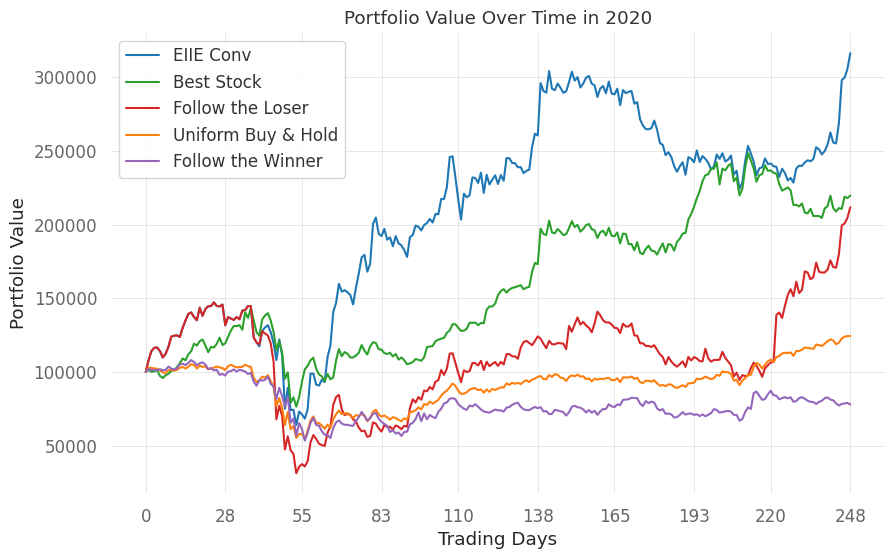

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(eiie_values, "tab:blue", label="EIIE Conv")
plt.plot(best_stock_values, "tab:green", label="Best Stock")
plt.plot(follow_loser_values, "tab:red", label="Follow the Loser")
plt.plot(ubah_values, "tab:orange", label="Uniform Buy & Hold")
plt.plot(follow_winner_values, "tab:purple", label="Follow the Winner")
plt.title("Portfolio Value Over Time in 2020")
plt.legend()
plt.xticks(
    np.round(np.linspace(0, len(eiie_values) - 1, 10))
)
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value")
plt.show()
plt.savefig("comparison.png", bbox_inches="tight")
plt.close()